# Actividad para resolver la tarea de análisis de sentimientos en textos

Hemos estudiado y comprendido los conceptos de los modelos secuenciales Ahora, aplicaremos estos conceptos en una tarea de análisis de sentimientos en comentarios de películas. Para este problema, usamos la base de datos disponible en [IMDB](https://keras.io/api/datasets/imdb/).


## Etapa 1: Se carga la base de datos.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_e

In [ ]:
# Se imprime un ejemplo de la base de datos. Este ejemplo corresponde a un
# comentario negativo; así, su etiqueta es 0.
for example, label in train_dataset.take(5):
  print('Texto: ', example.numpy())
  print('Etiqueta: ', label.numpy())

Texto:  [[   10    14  7542 ...  5024    32    10]
 [  308  9131   101 ...   338  3167 17761]
 [   56   340  1590 ...     0     0     0]
 ...
 [   10   284    11 ...    14    22    61]
 [   87  8716    14 ...     0     0     0]
 [   15     4  2032 ...     0     0     0]]
Etiqueta:  [0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1
 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1]
Texto:  [[  113     6   369 ...   145    94    99]
 [  312   675     5 ...     0     0     0]
 [  255    10    67 ...  1889     5     1]
 ...
 [  252   108     2 ...   733    15    50]
 [    1  5427   235 ...  2121    83 11860]
 [   29     5  7579 ...     0     0     0]]
Etiqueta:  [0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1]
Texto:  [[3820   13    4 ...    0    0    0]
 [1456 6346  809 ...    0    0    0]
 [ 869   10  153 ...  879    2 7787]
 ...
 [  11    7    4 ...    0    0    0]
 [  45  320

In [ ]:
# Se generan mini-lotes de la base de datos
buffer_size = 10000
batch_size = 64
#train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
#test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Etapa 2: Procesamiento de textos

Recordemos que los modelos de aprendizaje no funcionan cuando las entradas son textos. Así, es necesaria una primera etapa en donde codifiquemos, de forma numérica, las cadenas de caracteres.

**Pasos:**
1. Definir vocabulario (`max_features`) y longitud fija (`sequence_length`).
2. Crear y adaptar capa `TextVectorization`.
3. Vectorizar y emparejar con etiquetas.

In [ ]:
from tensorflow.keras.layers import TextVectorization

### 2.1 Tokenización y vectorización de texto

# Parámetros
max_features = 20000   # número máximo de palabras (vocabulario)
sequence_length = 200  # longitud máxima de cada comentario

# TextVectorization - Creamos la capa de vectorización
txt_vect = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

# Adaptamos la capa al corpus de entrenamiento
train_text = train_dataset.map(lambda text, label: text)
txt_vect.adapt(train_text)

In [ ]:
### 2.2 Aplicar vectorización a datasets - Función de vectorización
def vectorize_text(text, label):
    return txt_vect(text), label


# Aplicar vectorización y batching
train_dataset = train_dataset.map(vectorize_text)
test_dataset = test_dataset.map(vectorize_text)


# Aplicar shuffle, batching y prefetch después de la vectorización
train_dataset = (
    train_dataset
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
# Verificar ejemplo vectorizado
for x_batch, y_batch in train_dataset.take(1):
    print(x_batch.shape, y_batch.numpy()[:5])

print("\n")
(x_batch.shape, y_batch.numpy()[:5])

(64, 200) [1 1 1 1 1]




(TensorShape([64, 200]), array([1, 1, 1, 1, 1]))

## Etapa 3: Definición del modelo



Definimos una función para crear modelos RNN, LSTM o GRU bidireccionales.

**Arquitectura:**
- `Embedding(input_dim, output_dim)`
- `Bidirectional(RNN_Cell(units))`
- `Dropout(rate)`
- `Dense(1, activation='sigmoid')`

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import SimpleRNN

# Hiperparámetros
drop_rate = 0.3
embedding_dim = 128
rnn_units = 64

def build_model(cell_type='LSTM'):
    model = Sequential([
        tf.keras.Input(shape=(sequence_length,)),  # Capa Input para definir dimensión
        Embedding(input_dim=max_features, output_dim=embedding_dim, mask_zero=True),
        Dropout(drop_rate)
    ])

    if cell_type == 'LSTM':
        model.add(Bidirectional(LSTM(rnn_units)))
    elif cell_type == 'GRU':
        model.add(Bidirectional(GRU(rnn_units)))
    else:
        model.add(Bidirectional(SimpleRNN(rnn_units)))

    model.add(Dropout(drop_rate))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
# Mostrar resumen de un modelo LSTM
model1 = build_model('LSTM')
model1.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,658,945 (10.14 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

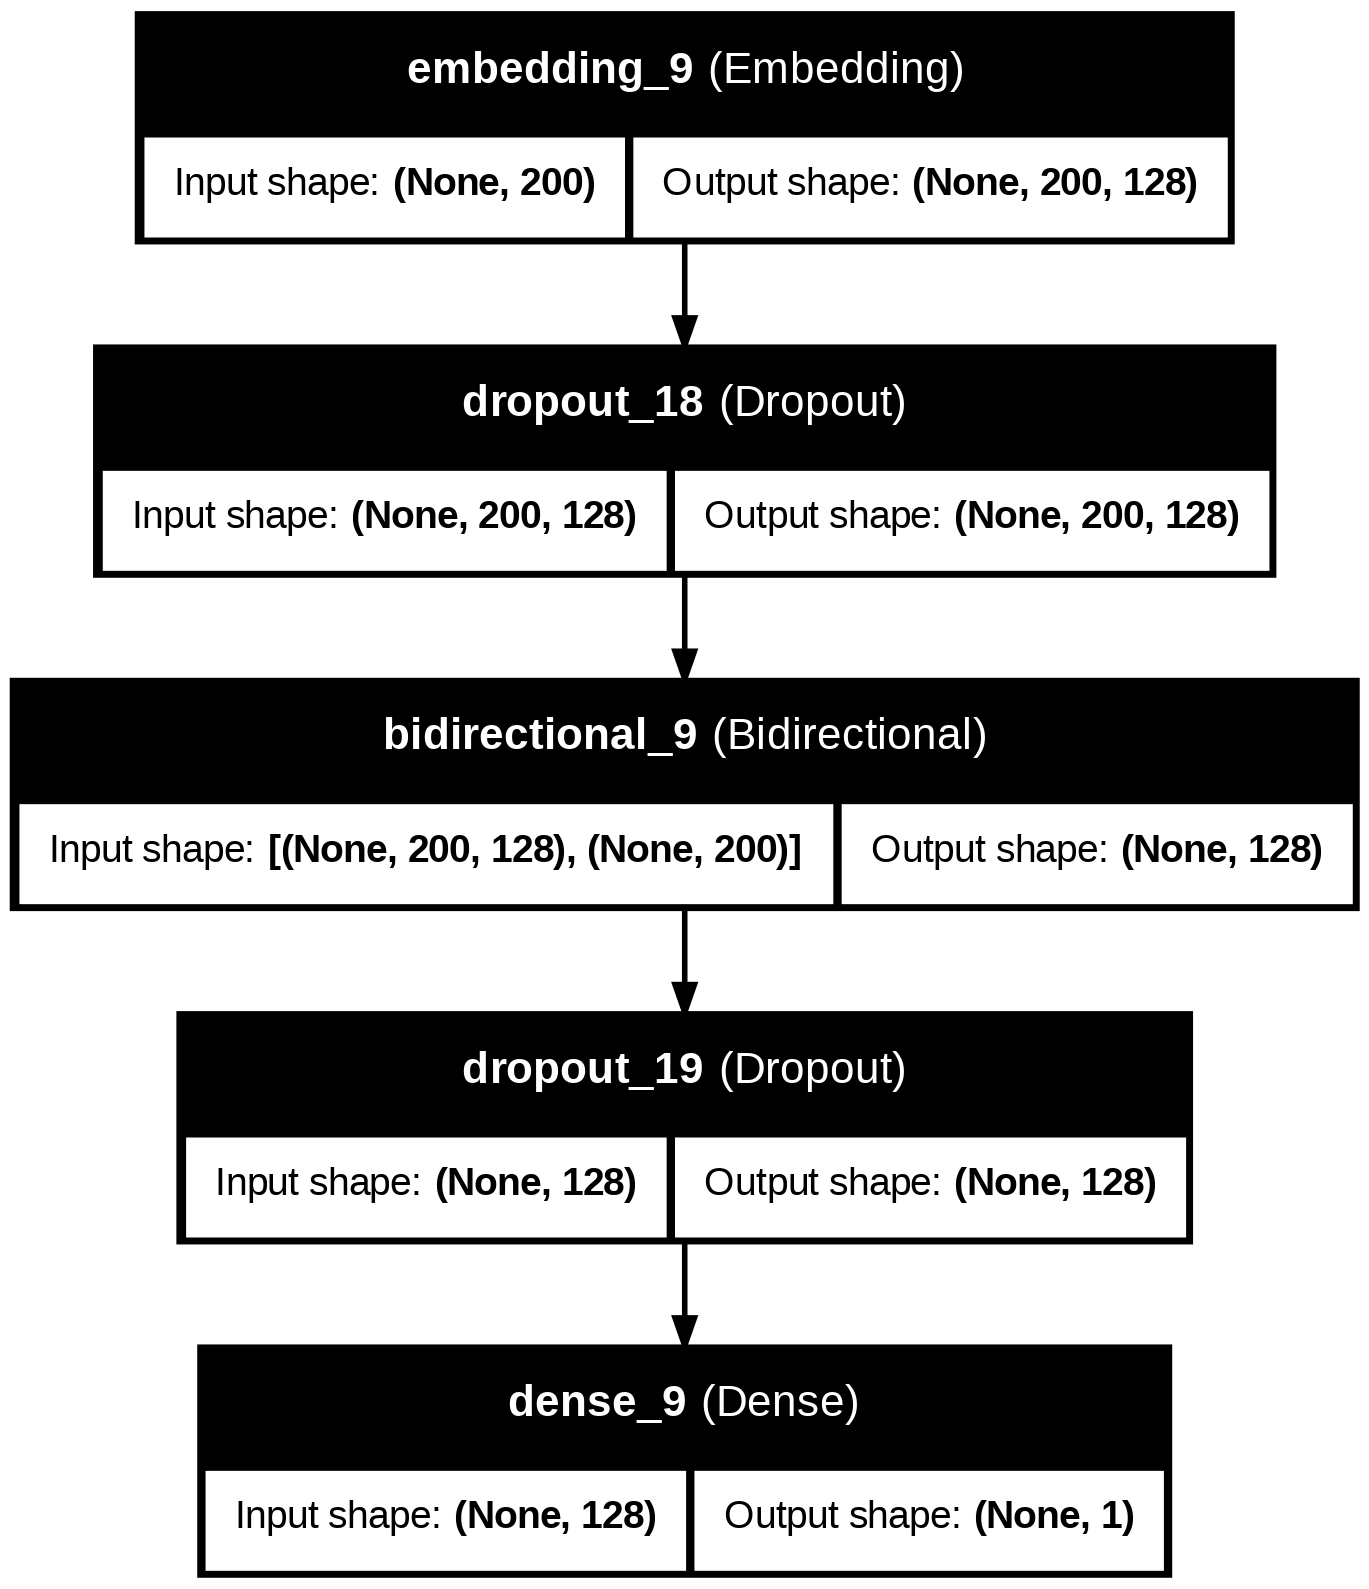

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model1, to_file='modelo_imdb.png', show_shapes=True, show_layer_names=True)
Image(filename='modelo_imdb.png')

# Etapa 4: Entrenamiento y evaluación del modelo

**Configuración de entrenamiento:**
- Optimizer: Adam
- Loss: binary_crossentropy
- Metrics: accuracy
- Épocas: 5 (ajustable)

In [ ]:
# 4.1 Compilación
model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])


# 4.2 Entrenamiento
epochs = 5
history1 = model1.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs)


# 4.3 Evaluación final
test_loss, test_acc = model1.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss:.4f} — Test Accuracy: {test_acc:.4f}")

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.7203 - loss: 0.5083 - val_accuracy: 0.8565 - val_loss: 0.3367
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.9165 - loss: 0.2168 - val_accuracy: 0.8510 - val_loss: 0.3569
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.9526 - loss: 0.1364 - val_accuracy: 0.8343 - val_loss: 0.4160
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - accuracy: 0.9685 - loss: 0.0914 - val_accuracy: 0.8394 - val_loss: 0.4623
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.9795 - loss: 0.0586 - val_accuracy: 0.8399 - val_loss: 0.6451
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8417 - loss: 0.6441

Test Loss: 0.6451 — Test Accuracy: 0.8399


# 5. Curvas de Aprendizaje

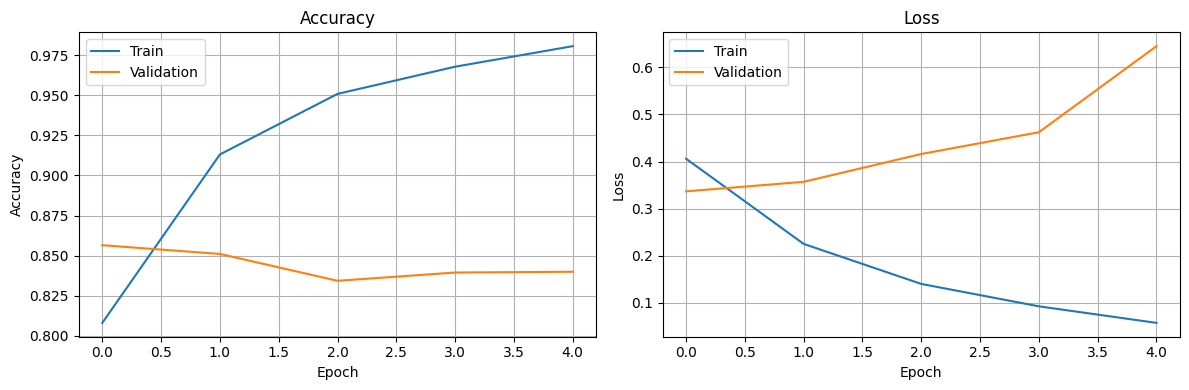

In [ ]:
plt.figure(figsize=(12,4))
# Accuracy
plt.subplot(1,2,1)
plt.plot(history1.history['accuracy'], label='Train')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss
plt.subplot(1,2,2)
plt.plot(history1.history['loss'], label='Train')
plt.plot(history1.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## **Análisis de Resultados**

Una vez que el modelo ha sido entrenado y evaluado, es crucial analizar las métricas de rendimiento y las curvas de aprendizaje para diagnosticar el comportamiento del modelo y entender si está aprendiendo de manera efectiva y generalizando bien a nuevos datos.

**Resultados de Evaluación Final (después de 5 épocas):**

- **Pérdida en el conjunto de prueba (Test Loss):** `0.6451`
- **Precisión en el conjunto de prueba (Test Accuracy):** `0.8399` (83.99%)

**Análisis de las Gráficas de Pérdida y Precisión (Entrenamiento de 5 Épocas):**

Observando las curvas generadas por `matplotlib`:

1.  **Gráfica de Pérdida (Loss):**
    * **Curva de Entrenamiento (línea azul):** Muestra una disminución constante y pronunciada a lo largo de las 5 épocas. Esto indica que el modelo está aprendiendo de manera efectiva de los datos de entrenamiento, ajustando sus pesos para minimizar la función de costo.
    * **Curva de Validación (línea naranja):** Inicialmente, la pérdida de validación también disminuye, lo cual es un signo positivo de que el modelo está empezando a generalizar. Sin embargo, aproximadamente a partir de la **época 2 o 3**, la curva de pérdida de validación comienza a estabilizarse, aplanarse e incluso muestra una ligera tendencia a aumentar o volverse más errática, mientras que la pérdida de entrenamiento continúa su descenso.
    * **Diagnóstico:** Esta divergencia clara entre la pérdida de entrenamiento (que sigue bajando) y la pérdida de validación (que se estanca o empeora) es el indicativo principal de **sobreajuste (overfitting)**. El modelo está empezando a "memorizar" los datos de entrenamiento, incluyendo el ruido y las particularidades del mismo, en lugar de aprender patrones generalizables. El valor final de `Test Loss` (0.6451) confirma que, si bien es una mejora respecto a un valor anterior, sigue habiendo margen para que el modelo haga predicciones más seguras y con menor incertidumbre en datos no vistos.

2.  **Gráfica de Precisión (Accuracy):**
    * **Curva de Entrenamiento (línea azul):** La precisión de entrenamiento muestra una mejora continua y constante, alcanzando valores muy altos (cercanos a 100%) al final de las épocas. Esto corrobora que el modelo está aprendiendo a clasificar los datos de entrenamiento casi a la perfección.
    * **Curva de Validación (línea naranja):** Similar a la pérdida, la precisión de validación aumenta rápidamente al principio, pero luego se estabiliza alrededor del 80-85% (coincidiendo con el `Test Accuracy` de 0.8399). La brecha entre la precisión de entrenamiento (muy alta) y la de validación (buena, pero inferior y estancada) se vuelve cada vez más pronunciada a medida que avanza el entrenamiento.
    * **Diagnóstico:** Esta diferencia creciente entre la precisión de entrenamiento y validación es otra fuerte señal de **sobreajuste**. El modelo tiene un rendimiento excelente en los datos que ha visto, pero su capacidad para predecir correctamente en datos nuevos y no vistos es limitada por la memorización.


## **Conclusiones y Próximos Pasos:**

El análisis de las curvas de aprendizaje y los resultados numéricos apuntan a un escenario de **sobreajuste**. El modelo es muy bueno y aprende rápidamente, pero después de unas pocas épocas (en este caso, a partir de la época **2 o 3 aprox**), empieza a especializarse demasiado en los datos de entrenamiento.

Para mejorar la capacidad de generalización del modelo y mitigar el sobreajuste, se podrían aplicar las siguientes estrategias:


1.  **Gestión de las Épocas de Entrenamiento:**
    - **Reducción de Épocas (Early Stopping):** Las gráficas sugieren que el punto óptimo para detener el entrenamiento, donde el rendimiento de validación deja de mejorar, se encuentra alrededor de la **época 2 o 3**. Implementar una técnica de `EarlyStopping` en Keras sería ideal para detener el entrenamiento automáticamente cuando la métrica de validación ya no mejora, evitando el sobreajuste que se observa en las últimas épocas.
    - **Considerar más épocas (en otros escenarios):** Es importante destacar que, en otros contextos o si el modelo mostrara subajuste (es decir, si tanto la pérdida de entrenamiento como la de validación fueran altas y aún estuvieran disminuyendo juntas), aumentar el número de épocas sería una estrategia válida. Sin embargo, para este modelo y los resultados actuales, aumentar las épocas solo exacerbaría el sobreajuste.

2.  **Ajuste de la Tasa de Dropout:** Aunque ya se incluyó una capa de Dropout (0.3) en la arquitectura, si el sobreajuste persiste, se podría experimentar con una tasa de dropout ligeramente mayor (por ejemplo, 0.4 o 0.5) para aumentar la regularización.
3.  **Regularización Adicional (L1/L2):** Podríamos considerar añadir regularización L1 o L2 directamente a las capas Dense o Recurrentes para penalizar el tamaño de los pesos del modelo y así reducir su complejidad.

# 6. Experimentos con Variantes

## **Modelo GRU**

In [ ]:
# Mostrar resumen de un modelo GRU
model2 = build_model('GRU')
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,634,625 (10.05 MB)

 Trainable params: 2,634,625 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4.1 Compilación
model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])


# 4.2 Entrenamiento
epochs = 5
history2 = model2.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs)


# 4.3 Evaluación final
test_loss, test_acc = model2.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss:.4f} — Test Accuracy: {test_acc:.4f}")

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.6524 - loss: 0.5812 - val_accuracy: 0.8581 - val_loss: 0.3326
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.9092 - loss: 0.2341 - val_accuracy: 0.8484 - val_loss: 0.3699
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9512 - loss: 0.1357 - val_accuracy: 0.8416 - val_loss: 0.4205
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.9778 - loss: 0.0672 - val_accuracy: 0.8390 - val_loss: 0.5318
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.9888 - loss: 0.0319 - val_accuracy: 0.8337 - val_loss: 0.6802
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8357 - loss: 0.6812

Test Loss: 0.6802 — Test Accuracy: 0.8337


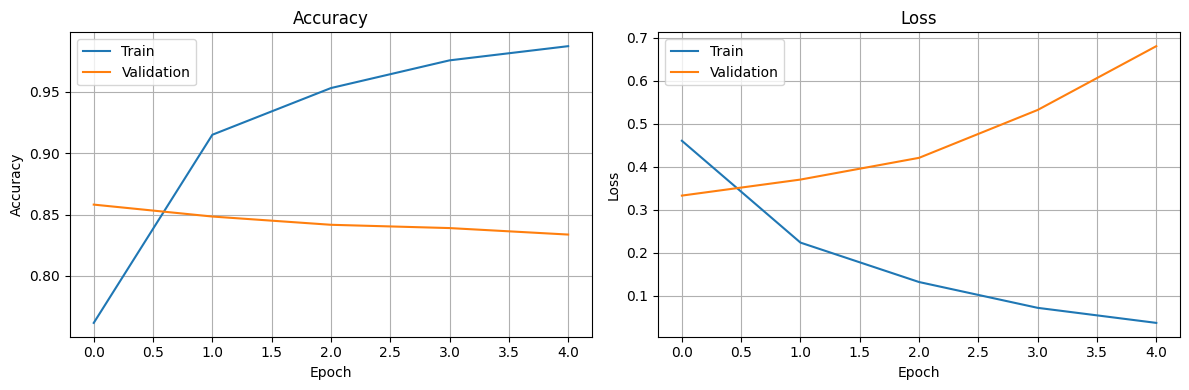

In [ ]:
plt.figure(figsize=(12,4))
# Accuracy
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss
plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Observando las curvas de la nueva gráfica generada para el modelo con GRU:

1.  **Gráfica de Pérdida (Loss) para GRU:**
    * **Curva de Entrenamiento (línea azul):** Muestra una disminución constante a lo largo de las 5 épocas, lo que indica que el modelo GRU está aprendiendo de los datos de entrenamiento y ajustando sus pesos para minimizar el error.
    * **Curva de Validación (línea naranja):** La pérdida de validación también disminuye inicialmente. Sin embargo, similar al modelo con LSTM y el diagnóstico anterior, a partir de la **época 2 o 3**, la curva de pérdida de validación comienza a aplanarse o incluso a mostrar una ligera tendencia al alza.
    * **Diagnóstico:** Este patrón es un claro indicador de **sobreajuste (overfitting)**. El modelo está empezando a memorizar los datos de entrenamiento, lo que se refleja en una pérdida de validación que no sigue la mejora de la pérdida de entrenamiento. El `Test Loss` final de `0.6802` es notablemente **más alto** que el del modelo LSTM anterior (`0.6050`), lo que sugiere que las predicciones del modelo GRU, aunque tienen una precisión comparable, son menos confiables o más inciertas en datos no vistos.

2.  **Gráfica de Precisión (Accuracy) para GRU:**
    * **Curva de Entrenamiento (línea azul):** La precisión de entrenamiento aumenta de manera constante, acercándose a valores muy altos (cercanos al 100%) al final de las épocas, lo que indica un buen ajuste a los datos de entrenamiento.
    * **Curva de Validación (línea naranja):** La precisión de validación también mejora en las primeras épocas, pero se estabiliza alrededor del 80-84% a partir de la época 2 o 3. La brecha creciente entre la precisión de entrenamiento y validación es nuevamente evidente.
    * **Diagnóstico:** Esto reconfirma el **sobreajuste**. El modelo GRU, aunque aprende bien del conjunto de entrenamiento, no generaliza tan eficazmente a partir de un cierto punto. El `Test Accuracy` de `0.8337%` es muy similar al del modelo LSTM (`0.8318%`), lo que indica un rendimiento de clasificación final comparable en términos de porcentaje de aciertos.

**Comparación y Conclusiones del Modelo GRU vs. Modelo LSTM:**

* **Rendimiento de Precisión:** Ambos modelos (LSTM y GRU) alcanzan una precisión en el conjunto de prueba muy similar (aproximadamente 83.3% - 83.5%). Esto sugiere que, para esta tarea de clasificación de sentimientos y con la configuración actual, ambas arquitecturas recurrentes son igualmente capaces de clasificar correctamente la polaridad de los comentarios.
* **Pérdida de Validación/Prueba:** Aquí es donde se observa una diferencia significativa. El modelo **GRU muestra una `Test Loss` más alta (`0.6802`)** en comparación con el modelo LSTM (`0.6050`). Una pérdida más baja es generalmente preferible, ya que indica que el modelo no solo acierta más (precisión), sino que lo hace con mayor confianza o menor error en sus estimaciones de probabilidad. Esto podría implicar que el GRU, aunque acierta casi la misma cantidad de veces, sus predicciones de probabilidad son menos "afiladas" o más "inciertas" en los casos correctos, y más erróneas en los casos incorrectos, en comparación con el LSTM.
* **Sobreajuste:** Ambos modelos exhiben claras señales de sobreajuste. La tendencia de las curvas de validación (estancamiento o ligero aumento) mientras las curvas de entrenamiento continúan mejorando es consistente entre ambas arquitecturas con 5 épocas de entrenamiento.

Este experimento demuestra que tanto LSTM como GRU son opciones viables para el análisis de sentimientos con rendimiento de precisión comparable, aunque el LSTM podría ofrecer predicciones más confiables (menor pérdida) en este caso específico. La gestión del sobreajuste es clave para optimizar el rendimiento de generalización de ambos modelos.

## **Modelo Simple RNN**

In [ ]:
model3 = build_model('SimpleRNN')
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,584,833 (9.86 MB)

 Trainable params: 2,584,833 (9.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4.1 Compilación
model3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])


# 4.2 Entrenamiento
epochs = 5
history3 = model3.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs)


# 4.3 Evaluación final
test_loss, test_acc = model3.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss:.4f} — Test Accuracy: {test_acc:.4f}")

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.5238 - loss: 0.6978 - val_accuracy: 0.5878 - val_loss: 0.7341
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.6488 - loss: 0.6324 - val_accuracy: 0.6160 - val_loss: 0.6430
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.7864 - loss: 0.4610 - val_accuracy: 0.6422 - val_loss: 0.6627
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9218 - loss: 0.2086 - val_accuracy: 0.7094 - val_loss: 0.6750
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9747 - loss: 0.0775 - val_accuracy: 0.7408 - val_loss: 0.7406
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7449 - loss: 0.7259

Test Loss: 0.7406 — Test Accuracy: 0.7408


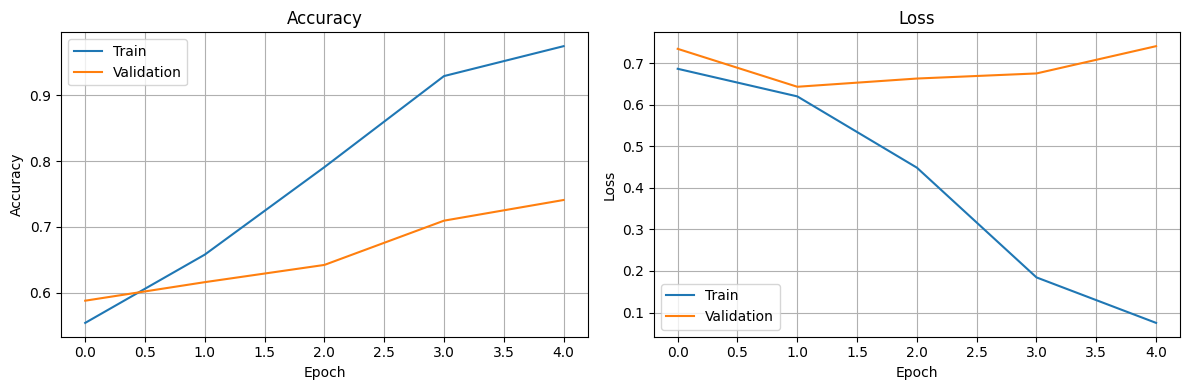

In [ ]:
plt.figure(figsize=(12,4))
# Accuracy
plt.subplot(1,2,1)
plt.plot(history3.history['accuracy'], label='Train')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss
plt.subplot(1,2,2)
plt.plot(history3.history['loss'], label='Train')
plt.plot(history3.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Análisis de las Gráficas de Pérdida y Precisión (Modelo con SimpleRNN - Entrenamiento de 5 Épocas):

Observando las curvas de la nueva gráfica generada para el modelo con SimpleRNN:

1.  **Gráfica de Pérdida (Loss) para SimpleRNN:**
    * **Curva de Entrenamiento (línea azul):** Muestra una disminución muy rápida y drástica de la pérdida, alcanzando valores muy bajos (`0.0775`) al final de la época 5. Esto indica que el modelo SimpleRNN aprende extremadamente rápido a ajustarse a los datos de entrenamiento.
    * **Curva de Validación (línea naranja):** La pérdida de validación disminuye en las primeras épocas, pero de forma mucho menos pronunciada que la de entrenamiento. Además, a partir de la **época 2 o 3**, la pérdida de validación comienza a estancarse y muestra una clara tendencia al aumento hacia el final del entrenamiento.
    * **Diagnóstico:** Esta divergencia es el indicativo más fuerte de **sobreajuste extremo**. El modelo SimpleRNN está memorizando casi por completo el conjunto de entrenamiento, pero está fallando gravemente en generalizar a datos no vistos. El `Test Loss` final de `0.7406` es el más alto de los tres modelos probados, lo que sugiere que las predicciones del SimpleRNN en el conjunto de prueba son significativamente menos confiables y más erróneas.

2.  **Gráfica de Precisión (Accuracy) para SimpleRNN:**
    * **Curva de Entrenamiento (línea azul):** La precisión de entrenamiento se dispara, alcanzando valores extremadamente altos (cercanos al 97%) en la época 5. Esto confirma la fuerte memorización del conjunto de entrenamiento.
    * **Curva de Validación (línea naranja):** La precisión de validación aumenta, pero se estabiliza a un nivel considerablemente más bajo (alrededor del 70-74%) desde la época 2 o 3. La brecha entre la precisión de entrenamiento y validación es enorme.
    * **Diagnóstico:** Esta diferencia abismal entre la precisión de entrenamiento y validación es la confirmación más contundente del **sobreajuste severo**. El modelo tiene un rendimiento muy pobre en la generalización. El `Test Accuracy` de `0.7408%` es notablemente más bajo que el de los modelos LSTM y GRU.

**Comparación y Conclusiones del Modelo SimpleRNN vs. LSTM/GRU:**

* **Rendimiento General:** El modelo SimpleRNN muestra un rendimiento significativamente inferior en el conjunto de prueba (`Test Accuracy: 0.7408%`) en comparación con los modelos LSTM (`0.8318%`) y GRU (`0.8337%`). Su `Test Loss` (`0.7406`) es también considerablemente más alta.

* **Capacidad de Manejo de Dependencias Largas:** La arquitectura SimpleRNN, por su naturaleza, sufre del problema del desvanecimiento de gradientes (vanishing gradients) y tiene dificultades para capturar dependencias a largo plazo en secuencias. Los comentarios de películas son textos relativamente largos, y la incapacidad de SimpleRNN para recordar información relevante de las primeras partes del comentario probablemente contrib

# 7. Experimentos Variando Épocas

Además de comparar arquitecturas, es útil analizar cómo el número de épocas influye en el rendimiento.

- Seguiremos utilizando el **modelo LSTM**

In [ ]:
epoch_values = [10, 20, 40]
results = {}
histories = {}
for ep in epoch_values:
    print(f"======= Epochs: {ep} =======")
    m = build_model('LSTM')  # por defecto LSTM, se puede cambiar
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    h = m.fit(train_dataset, validation_data=test_dataset, epochs=ep)

    histories[ep] = h

    loss, acc = m.evaluate(test_dataset)
    results[ep] = acc
    print(f"Test Accuracy (epochs={ep}): {acc:.4f}")

# Mostrar resultados agrupados
for ep, acc in results.items():
    print(f"Épocas: {ep} -> Accuracy: {acc:.4f}")

======= Epochs: 10 =======
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.7143 - loss: 0.5195 - val_accuracy: 0.8563 - val_loss: 0.3393
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.9101 - loss: 0.2428 - val_accuracy: 0.8429 - val_loss: 0.3745
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9452 - loss: 0.1463 - val_accuracy: 0.8385 - val_loss: 0.4834
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9668 - loss: 0.0948 - val_accuracy: 0.8369 - val_loss: 0.4746
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9849 - loss: 0.0456 - val_accuracy: 0.8273 - val_loss: 0.5826
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.9889 - loss: 0.0330 - val_accuracy: 0.8152 - val_loss: 0.7694
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.9899 - loss: 0.0288 - val_accuracy: 0.8319 - val_loss: 0.7168
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accurac


--- Graficando Curvas de Aprendizaje por Época ---


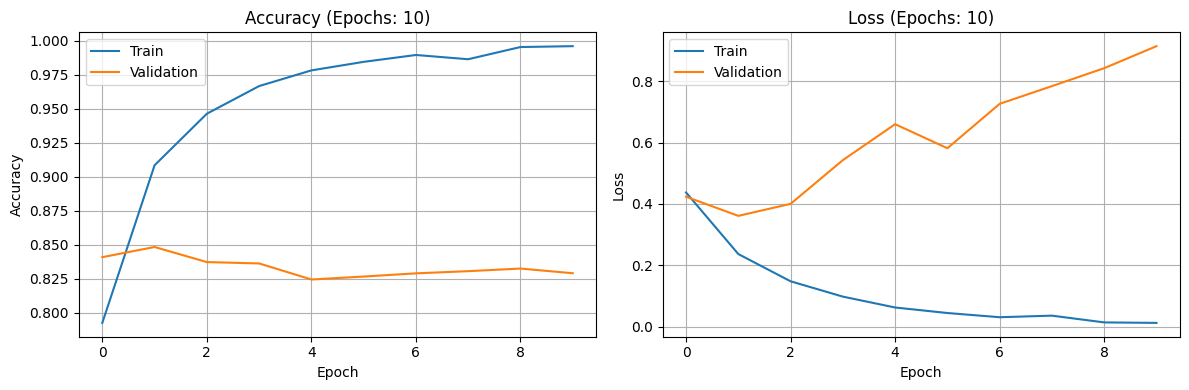

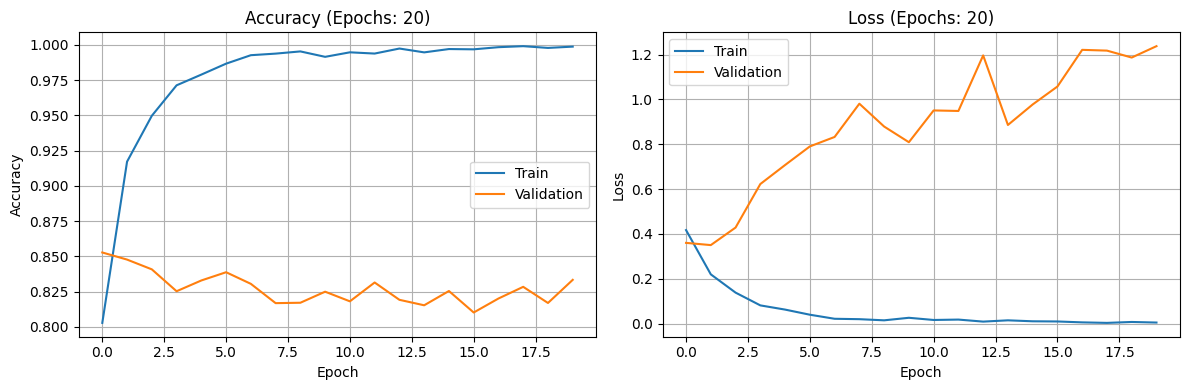

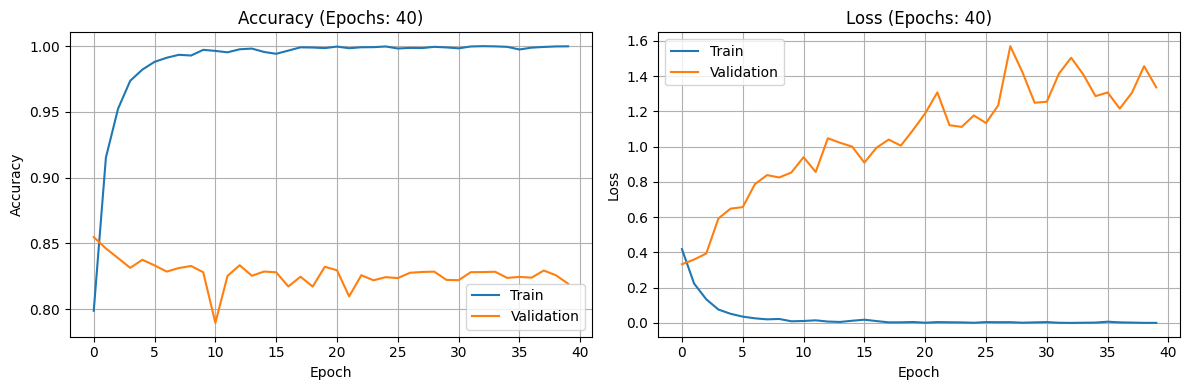

In [ ]:
# --- Graficar las curvas para cada historial ---
print("\n--- Graficando Curvas de Aprendizaje por Época ---")
for ep, history in histories.items():
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'Accuracy (Epochs: {ep})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'Loss (Epochs: {ep})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

Análisis de las Gráficas de Pérdida y Precisión (Modelo LSTM con diferentes Épocas):

La gráfica proporcionada muestra las curvas de pérdida y precisión para las tres ejecuciones (10, 20, y 40 épocas). Observamos el siguiente comportamiento:

1.  **Modelo LSTM con 10 Épocas (Líneas más claras):**
    * Las curvas de entrenamiento (azul claro) muestran una mejora continua.
    * Las curvas de validación (naranja claro) mejoran rápidamente en las primeras épocas y luego comienzan a aplanarse.
    * Este punto de 10 épocas parece ser donde el modelo alcanza un buen equilibrio, obteniendo la **mayor `Test Accuracy` (0.8384)** entre los tres experimentos. Aunque ya hay señales de sobreajuste hacia el final de estas 10 épocas (la pérdida de validación ya no baja significativamente, y la precisión de validación se estabiliza mientras la de entrenamiento sigue subiendo), el rendimiento de generalización es óptimo.

2.  **Modelo LSTM con 20 Épocas (Líneas de tono medio):**
    * Las curvas de entrenamiento continúan mostrando una mejora constante, con la pérdida de entrenamiento disminuyendo y la precisión de entrenamiento aumentando hacia el 100%.
    * Las curvas de validación muestran una tendencia más clara de **sobreajuste pronunciado**. La pérdida de validación deja de mejorar temprano y comienza a subir, y la precisión de validación se estanca o incluso disminuye ligeramente después de un pico inicial, mientras que la precisión de entrenamiento sigue creciendo considerablemente.
    * El `Test Accuracy` de `0.8359` es ligeramente inferior al de 10 épocas, lo que confirma que el entrenamiento adicional más allá del punto óptimo está causando que el modelo se sobreajuste y pierda capacidad de generalización.

3.  **Modelo LSTM con 40 Épocas (Líneas más oscuras):**
    * El patrón de sobreajuste es aún más evidente. Las curvas de entrenamiento casi tocan los límites de la gráfica, indicando una memorización casi perfecta de los datos de entrenamiento.
    * Las curvas de validación divergen drásticamente de las de entrenamiento. La pérdida de validación sube significativamente, y la precisión de validación experimenta un descenso claro después de un pico temprano.
    * El `Test Accuracy` de `0.8267` es el más bajo de los tres, demostrando que un número excesivo de épocas perjudica seriamente el rendimiento del modelo en datos no vistos debido al **sobreajuste severo**.

**Conclusiones de la Influencia del Número de Épocas:**

Este experimento demuestra claramente la importancia de seleccionar el número de épocas adecuado para el entrenamiento de una red neuronal:

- **El sobreajuste es un factor crítico:** Entrenar el modelo durante demasiadas épocas (20 y especialmente 40) provoca un sobreajuste significativo, donde el modelo memoriza el conjunto de entrenamiento y pierde su capacidad para generalizar a datos nuevos. Esto se manifiesta en una `Test Accuracy` decreciente y una `Test Loss` creciente a medida que aumentan las épocas.
- **Punto óptimo de entrenamiento:** Para este modelo LSTM y este dataset, el rendimiento óptimo en el conjunto de prueba se logra con **alrededor de 10 épocas**. Entrenamientos más cortos (como las 5 épocas iniciales) podrían haber dejado al modelo subajustado (sin haber aprendido lo suficiente), mientras que entrenamientos más largos llevan a un sobreajuste perjudicial.
- **Importancia de Early Stopping:** Este análisis refuerza la necesidad de implementar una estrategia de `Early Stopping` en la fase de entrenamiento. Esta técnica detendría automáticamente el entrenamiento cuando el rendimiento en el conjunto de validación (ya sea pérdida o precisión) deje de mejorar, previniendo el sobreajuste y asegurando que el modelo se guarde en su mejor punto de generalización.